In [1]:
!pip install pyarrow

In [2]:
!pip install zensvi keras tensorflow census us opencv-python pandas

In [3]:
# Import relevant libaries
from census import Census
from us import states
import pandas as pd
import requests
import os
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt
import random
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [17]:
# Load panoptic segmentation CSV
panoptic_file_path = "/Volumes/MRDALLMAYR/data/segment_data/summary_output/panoptic_label_counts.csv"  
panoptic_data = pd.read_csv(panoptic_file_path)

# Load semantic segmentation data csv 
semantic_file_path = "/Volumes/MRDALLMAYR/data/segment_data/summary_output/semantic_pixel_ratios.csv"  
semantic_data = pd.read_csv(semantic_file_path)

In [18]:
panoptic_data.head()

,Number,filename_key,label_name,label_counts
0,0.0,block_482012111023_point_19_heading_270,Building,1.0
1,1.0,block_482012111023_point_19_heading_270,Fence,1.0
2,2.0,block_482012111023_point_19_heading_270,Curb,1.0
3,3.0,block_482012111023_point_19_heading_270,Sky,1.0
4,4.0,block_482012111023_point_19_heading_270,Sidewalk,1.0


In [19]:
semantic_data.head()

,Number,filename_key,label_name,pixel_ratios
0,0.0,block_482012111023_point_19_heading_270,Curb,0.017048
1,1.0,block_482012111023_point_19_heading_270,Fence,0.056677
2,2.0,block_482012111023_point_19_heading_270,Road,0.236050
3,3.0,block_482012111023_point_19_heading_270,Sidewalk,0.033201
4,4.0,block_482012111023_point_19_heading_270,Building,0.130920


In [28]:
# Extract block_group_id into a new column from filename_key for later block-group level analysis 
panoptic_data['block_group_id'] = panoptic_data['filename_key'].str.extract(r'block_(\d+)_')[0]
semantic_data['block_group_id'] = semantic_data['filename_key'].str.extract(r'block_(\d+)_')[0]

In [8]:
panoptic_data.head()

,Number,filename_key,label_name,label_counts,block_group_id
0,0.0,block_482012111023_point_19_heading_270,Building,1.0,482012111023
1,1.0,block_482012111023_point_19_heading_270,Fence,1.0,482012111023
2,2.0,block_482012111023_point_19_heading_270,Curb,1.0,482012111023
3,3.0,block_482012111023_point_19_heading_270,Sky,1.0,482012111023
4,4.0,block_482012111023_point_19_heading_270,Sidewalk,1.0,482012111023


In [9]:
semantic_data.head()
semantic_data = semantic_data.fillna(0)

In [22]:
# Define the entropy-based calculation function
def calculate_vc(group):
    pixel_ratios = group['pixel_ratios'].values
    pixel_ratios = pixel_ratios[pixel_ratios > 0]  # Exclude zeros or negligible values
    n = len(pixel_ratios)
    if n == 0:
        return 0  # If no valid ratios, return 0
    vc = -np.sum(pixel_ratios * np.log(pixel_ratios)) / np.log(n)
    return vc

# Calculate VC per image
vc_per_image = (
    semantic_data.groupby('filename_key')
    .apply(calculate_vc)
    .reset_index(name='VC')
)

# Add block group information for each image
vc_per_image['block_group'] = vc_per_image['filename_key'].str.extract(r'block_(\d+)_')

# Save VC per image to a CSV file
vc_per_image.to_csv('vc_per_image.csv', index=False)

# Aggregate VC by block group
vc_per_block_group = (
    vc_per_image.groupby('block_group')['VC']
    .mean()
    .reset_index(name='mean_VC')
)

# Save VC per block group to a CSV file
vc_per_block_group.to_csv('vc_per_block_group.csv', index=False)

# Display the final results
print(vc_per_image)
print(vc_per_block_group)


<ipython-input-22-bf6ef1e897f9>:8: RuntimeWarning: invalid value encountered in scalar divide
  vc = -np.sum(pixel_ratios * np.log(pixel_ratios)) / np.log(n)


                                 filename_key        VC   block_group
0        block_482011000011_point_0_heading_0  0.651869  482011000011
1      block_482011000011_point_0_heading_180  0.560760  482011000011
2      block_482011000011_point_0_heading_270  0.719137  482011000011
3       block_482011000011_point_0_heading_90  0.644895  482011000011
4       block_482011000011_point_10_heading_0  0.636905  482011000011
...                                       ...       ...           ...
18551  block_482012124001_point_99_heading_90  0.576663  482012124001
18552    block_482012124001_point_9_heading_0  0.699235  482012124001
18553  block_482012124001_point_9_heading_180  0.701949  482012124001
18554  block_482012124001_point_9_heading_270  0.820455  482012124001
18555   block_482012124001_point_9_heading_90  0.746315  482012124001

[18556 rows x 3 columns]
     block_group   mean_VC
0   482011000011  0.618766
1   482011000012  0.622601
2   482012104001  0.664008
3   482012104002  0.687612

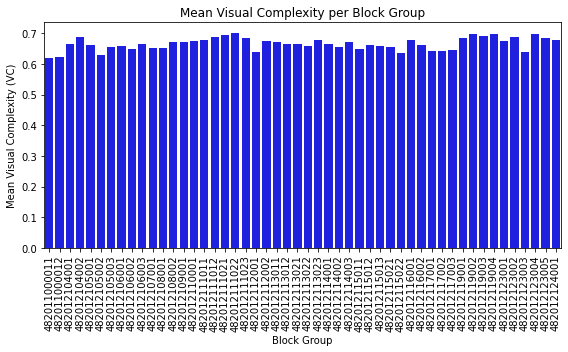

In [23]:
# Bar Chart: Visual Complexity per Block Group
import seaborn as sns
bar_color1 = "#fa8775"
bar_color2 = "#0000ff"
plt.figure(figsize=(8, 5))
sns.barplot(data=vc_per_block_group, x='block_group', y='mean_VC', color=bar_color2)
plt.title('Mean Visual Complexity per Block Group')
plt.xlabel('Block Group')
plt.ylabel('Mean Visual Complexity (VC)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

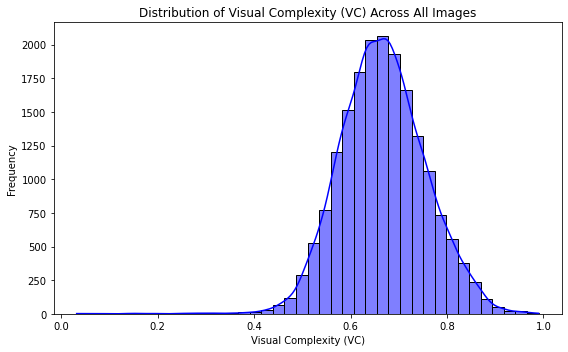

In [32]:
# Histogram: Distribution of VC Across All Images
plt.figure(figsize=(8, 5))
sns.histplot(data=vc_per_image, x='VC', bins=40, kde=True, color=bar_color2)
plt.title('Distribution of Visual Complexity (VC) Across All Images')
plt.xlabel('Visual Complexity (VC)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [25]:
# Merge total avg pixel ratios back into the aggregated data
total_seg_data = panoptic_data.merge(
    semantic_data, on='filename_key', how='left'
)

total_seg_data.head()

,Number_x,filename_key,label_name_x,label_counts,Geoid,Number_y,label_name_y,pixel_ratios,block_group_id
0,0.0,block_482012111023_point_19_heading_270,Building,1.0,482012111023,0.0,Curb,0.017048,482012111023
1,0.0,block_482012111023_point_19_heading_270,Building,1.0,482012111023,1.0,Fence,0.056677,482012111023
2,0.0,block_482012111023_point_19_heading_270,Building,1.0,482012111023,2.0,Road,0.236050,482012111023
3,0.0,block_482012111023_point_19_heading_270,Building,1.0,482012111023,3.0,Sidewalk,0.033201,482012111023
4,0.0,block_482012111023_point_19_heading_270,Building,1.0,482012111023,4.0,Building,0.130920,482012111023


In [26]:
# Calculate the mean pixel ratios for each category in block groups 
mean_agg_ratios = (
    semantic_data.groupby(['block_group_id', 'label_name'])
    .agg(avg_pixels=('pixel_ratios', 'mean'))
    .reset_index()
)

mean_agg_ratios.head(10)

,block_group_id,label_name,avg_pixels
0,482011000011,Banner,0.002993
1,482011000011,Barrier,0.034386
2,482011000011,Bench,0.003285
3,482011000011,Bicycle,0.002623
4,482011000011,Bike Lane,0.024221
5,482011000011,Bike Rack,0.010850
6,482011000011,Billboard,0.008333
7,482011000011,Bird,0.009728
8,482011000011,Bridge,0.090859
9,482011000011,Building,0.225238


In [29]:
# Calculate the mean pixel ratios for each category in block groups 
mean_agg_labels = (
    panoptic_data.groupby(['block_group_id', 'label_name'])
    .agg(avg_counts=('label_counts', 'mean'))
    .reset_index()
)

# Aggregate label_counts for each label_name by block_group_id
sum_agg_labels = (
    panoptic_data.groupby(['block_group_id', 'label_name'])
    .agg(total_counts=('label_counts', 'sum'))
    .reset_index()
)

In [47]:
mean_agg_labels.head()

,block_group_id,label_name,avg_counts
0,482011000011,Banner,1.333333
1,482011000011,Barrier,1.000000
2,482011000011,Bench,1.250000
3,482011000011,Bicycle,1.142857
4,482011000011,Bike Lane,1.000000


In [ ]:
sum_agg_labels.head()

## Analysis of Semantic Data 

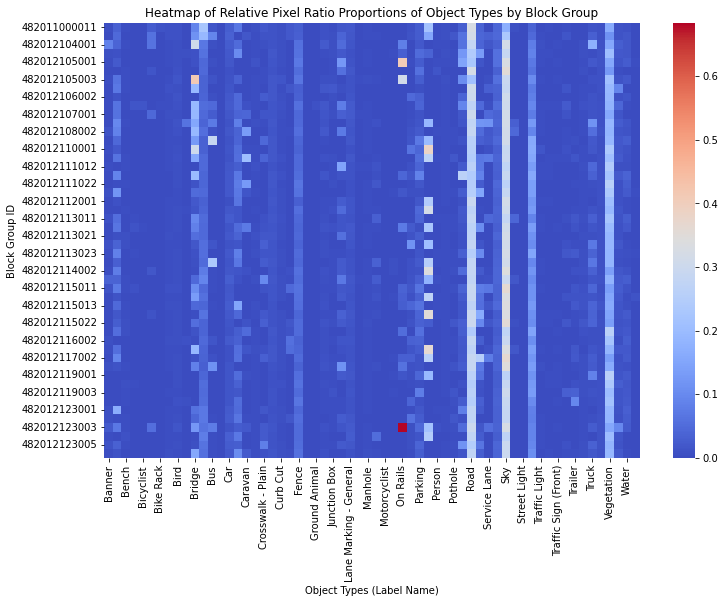

In [50]:
# Heatmap of relative pixel ratio values for block groups 
import seaborn as sns

# Create a pivot table for proportions
pivot_table = mean_agg_ratios.pivot(
    index='block_group_id', columns='label_name', values='avg_pixels'
).fillna(0)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='coolwarm', annot=False)
plt.title('Heatmap of Relative Pixel Ratio Proportions of Object Types by Block Group')
plt.xlabel('Object Types (Label Name)')
plt.ylabel('Block Group ID')
plt.show()


In [65]:
# Calculate relative proportions of the pixel ratios of object types within each block group
# Compute total ratios per block_group_id
total_pixel_ratios_per_group = (
    mean_agg_ratios.groupby('block_group_id')['avg_pixels'].sum().reset_index()
)
total_pixel_ratios_per_group.rename(columns={'avg_pixels': 'total_pixels'}, inplace=True)

# Merge total avg pixel ratios back into the aggregated data
total_semantic_agg = mean_agg_ratios.merge(
    total_pixel_ratios_per_group, on='block_group_id', how='left'
)

total_semantic_agg.head()


# Calculate proportions for each label_name within each block group
total_semantic_agg['relative_ratios'] = (
    total_semantic_agg['avg_pixels'] / total_semantic_agg['total_pixels']
)
total_semantic_agg.head()

,block_group_id,label_name,avg_pixels,total_pixels,relative_ratios
0,482011000011,Banner,0.002993,1.797607,0.001665
1,482011000011,Barrier,0.034386,1.797607,0.019129
2,482011000011,Bench,0.003285,1.797607,0.001827
3,482011000011,Bicycle,0.002623,1.797607,0.001459
4,482011000011,Bike Lane,0.024221,1.797607,0.013474


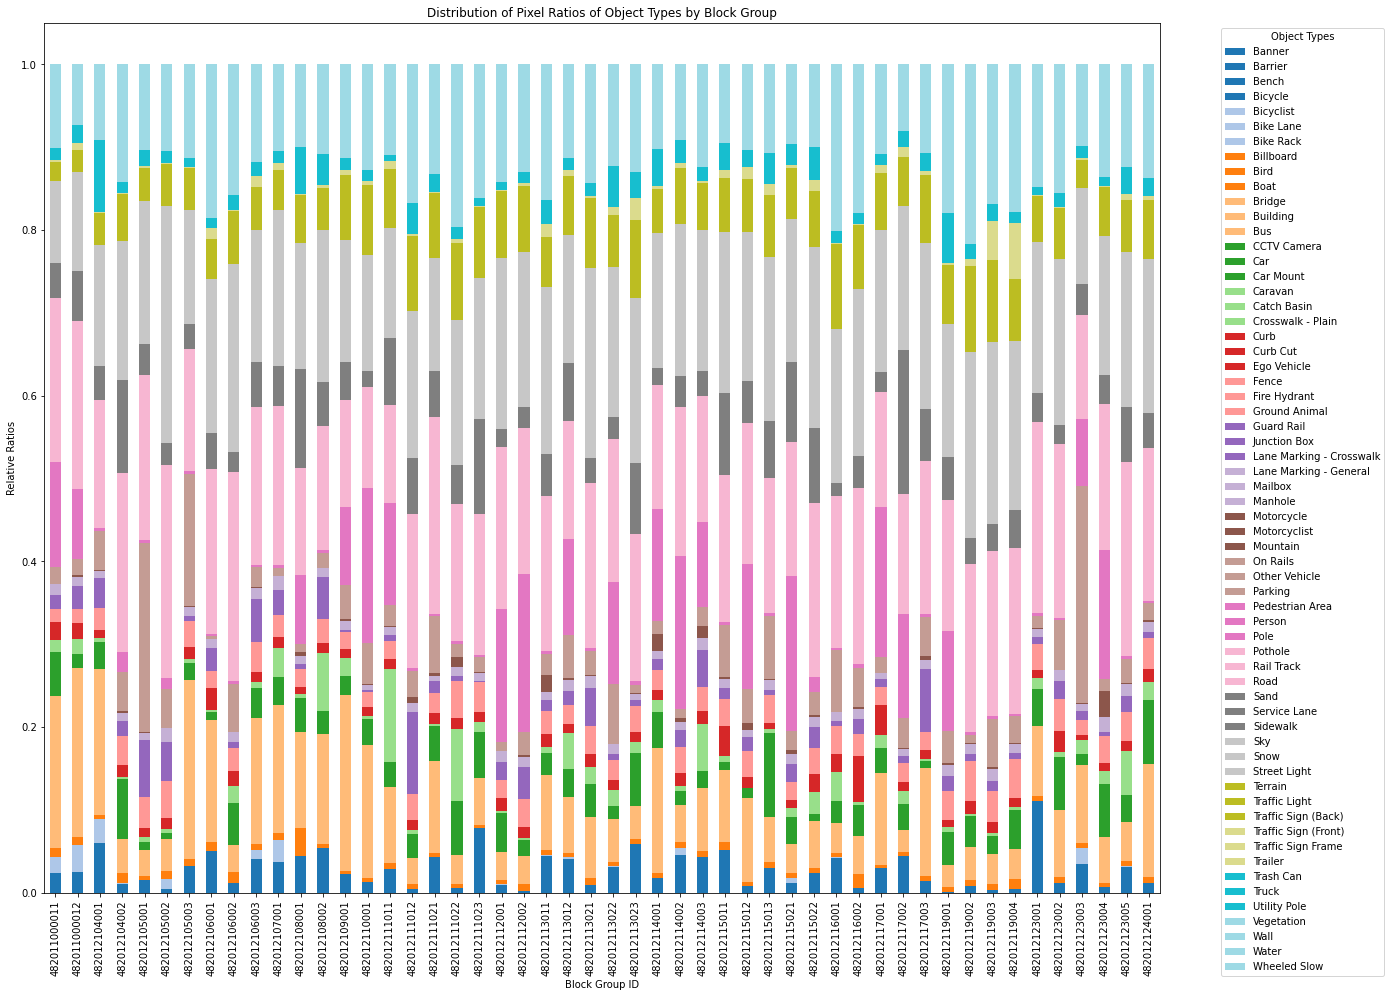

In [71]:
# Create a stacked bar chart
pivot_table_counts = total_semantic_agg.pivot(
    index='block_group_id', columns='label_name', values='relative_ratios'
).fillna(0)

pivot_table_counts.plot(kind='bar', stacked=True, figsize=(20, 16), colormap='tab20')
plt.title('Distribution of Pixel Ratios of Object Types by Block Group')
plt.xlabel('Block Group ID')
plt.ylabel('Relative Ratios')
plt.legend(title='Object Types', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## Geospatial Analysis

In [148]:
census_data = pd.read_parquet("/Volumes/MRDALLMAYR/data/census_data/census.parquet")
BG_shp_df = pd.read_csv("/Volumes/MRDALLMAYR/data/tx201bgdata.csv")
BG_census_df = pd.merge(BG_shp_df, census_data, how="left", on="GEOID20")
BG_census_df['geometry'] = BG_census_df['WKT'].apply(wkt.loads)
BG_census_gdf = gpd.GeoDataFrame(BG_census_df, geometry='geometry')

# 50 block groups for the initial analysis 
BG50_gdf = BG_census_gdf[:50]
BG50_gdf.head()

,WKT,STATEFP20,COUNTYFP20,TRACTCE20,BLKGRPCE20,GEOID20,NAMELSAD20,MTFCC20,FUNCSTAT20,ALAND20,...,INTPTLAT20,INTPTLON20,B19013_001E,B01001_001E,B08301_010E,state,county,tract,block group,geometry
0,"MULTIPOLYGON (((-95.374602 29.757612,-95.37457...",48,201,100001,1,482011000011,Block Group 1,G5030,S,1487729,...,29.752229,-95.366671,116892.0,2451.0,173.0,48,201,100001,1,"MULTIPOLYGON (((-95.37460 29.75761, -95.37457 ..."
1,"MULTIPOLYGON (((-95.362864 29.757924,-95.36227...",48,201,100001,2,482011000012,Block Group 2,G5030,S,1062631,...,29.759026,-95.356289,79615.0,2639.0,26.0,48,201,100001,2,"MULTIPOLYGON (((-95.36286 29.75792, -95.36227 ..."
2,"MULTIPOLYGON (((-95.371922 29.790763,-95.37184...",48,201,210400,1,482012104001,Block Group 1,G5030,S,1236805,...,29.789361,-95.366630,44421.0,2187.0,61.0,48,201,210400,1,"MULTIPOLYGON (((-95.37192 29.79076, -95.37184 ..."
3,"MULTIPOLYGON (((-95.366088 29.786579,-95.36599...",48,201,210400,2,482012104002,Block Group 2,G5030,S,575150,...,29.786348,-95.360949,29004.0,2457.0,138.0,48,201,210400,2,"MULTIPOLYGON (((-95.36609 29.78658, -95.36599 ..."
4,"MULTIPOLYGON (((-95.367937 29.798186,-95.36792...",48,201,210500,1,482012105001,Block Group 1,G5030,S,598129,...,29.797283,-95.362187,42330.0,1678.0,33.0,48,201,210500,1,"MULTIPOLYGON (((-95.36794 29.79819, -95.36793 ..."


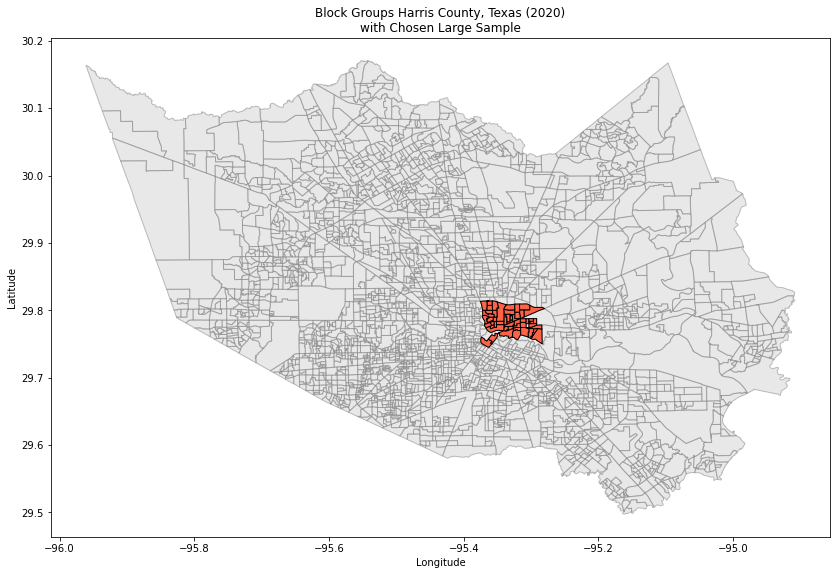

"# Clean data and filter\nBG_census_gdf.loc[BG_census_gdf['B19013_001E'] == -666666666.0, 'B19013_001E'] = np.nan\nfiltered_BG_gdf = BG_census_gdf.dropna(subset=['B19013_001E'])"

In [149]:

# Create the main figure with the larger map
fig, ax1 = plt.subplots(figsize=(12, 8))  # Larger main map

# Plot the full county on the main axis
BG_census_gdf.plot(ax=ax1, color='lightgrey', edgecolor='grey', alpha=0.5)
BG50_gdf.plot(ax=ax1, edgecolor='k', color="tomato")
ax1.set_title("Block Groups Harris County, Texas (2020)\nwith Chosen Large Sample")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

# still need to analyze how many samples i actually have here...

"""# Clean data and filter
BG_census_gdf.loc[BG_census_gdf['B19013_001E'] == -666666666.0, 'B19013_001E'] = np.nan
filtered_BG_gdf = BG_census_gdf.dropna(subset=['B19013_001E'])"""

In [151]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

# Pivot segmentation data to create one column per object type
segmentation_pivot = total_semantic_agg.pivot(
    index="block_group_id",
    columns="label_name",
    values="relative_ratios"
).reset_index()
segmentation_pivot.head()

label_name,block_group_id,Banner,Barrier,Bench,Bicycle,Bicyclist,Bike Lane,Bike Rack,Billboard,Bird,...,Traffic Sign (Front),Traffic Sign Frame,Trailer,Trash Can,Truck,Utility Pole,Vegetation,Wall,Water,Wheeled Slow
0,482011000011,0.001665,0.019129,0.001827,0.001459,NaN,0.013474,0.006036,0.004635,0.005412,...,0.001147,0.001632,NaN,0.001344,0.007047,0.005844,0.089132,0.006693,0.005251,NaN
1,482011000012,NaN,0.023329,0.001358,0.000598,0.001317,0.031506,0.000013,0.004368,0.004661,...,0.001083,0.007381,NaN,0.001097,0.015964,0.004294,0.058862,0.005851,0.008402,NaN
2,482012104001,0.039618,0.017347,0.001930,0.001143,NaN,0.029059,NaN,0.001964,0.003190,...,0.001436,NaN,NaN,0.003509,0.078564,0.004724,0.070641,0.012574,0.007719,NaN
3,482012104002,0.004637,0.005073,0.001264,NaN,0.000892,NaN,NaN,0.002931,0.004654,...,0.001338,NaN,NaN,0.003657,0.002384,0.007408,0.120034,0.011074,0.010348,NaN
4,482012105001,0.002146,0.011345,0.001390,NaN,NaN,NaN,NaN,0.002120,0.003645,...,0.002511,NaN,NaN,0.001849,0.010865,0.006211,0.080888,0.008095,0.012778,0.001493


In [152]:
# Make a copy of BG50 
BG50_gdf = BG50_gdf.copy()

# Ensure no issue with merging 
segmentation_pivot.loc[:, 'block_group_id'] = segmentation_pivot['block_group_id'].astype(str)
BG50_gdf.loc[:,'GEOID20'] = BG50_gdf['GEOID20'].astype(str)
print(segmentation_pivot.head())
print(BG50_gdf.head())
# Merge census data with segmentation data
BG_census_semantic_data = pd.merge(
    BG50_gdf, 
    segmentation_pivot, 
    left_on="GEOID20", 
    right_on="block_group_id", 
    how="left"
)
print(BG_census_semantic_data.head())

label_name block_group_id    Banner   Barrier     Bench   Bicycle  Bicyclist  \
0            482011000011  0.001665  0.019129  0.001827  0.001459        NaN   
1            482011000012       NaN  0.023329  0.001358  0.000598   0.001317   
2            482012104001  0.039618  0.017347  0.001930  0.001143        NaN   
3            482012104002  0.004637  0.005073  0.001264       NaN   0.000892   
4            482012105001  0.002146  0.011345  0.001390       NaN        NaN   

label_name  Bike Lane  Bike Rack  Billboard      Bird  ...  \
0            0.013474   0.006036   0.004635  0.005412  ...   
1            0.031506   0.000013   0.004368  0.004661  ...   
2            0.029059        NaN   0.001964  0.003190  ...   
3                 NaN        NaN   0.002931  0.004654  ...   
4                 NaN        NaN   0.002120  0.003645  ...   

label_name  Traffic Sign (Front)  Traffic Sign Frame  Trailer  Trash Can  \
0                       0.001147            0.001632      NaN   0.0013

In [156]:

# Convert merged data into a GeoDataFrame
BG_census_semantic_gdf = gpd.GeoDataFrame(BG_census_semantic_data, geometry="geometry")

# Fill Nan values as 0 
BG_census_semantic_gdf = BG_census_semantic_gdf.fillna(0)
BG_census_semantic_gdf.head()

,WKT,STATEFP20,COUNTYFP20,TRACTCE20,BLKGRPCE20,GEOID20,NAMELSAD20,MTFCC20,FUNCSTAT20,ALAND20,...,Traffic Sign (Front),Traffic Sign Frame,Trailer,Trash Can,Truck,Utility Pole,Vegetation,Wall,Water,Wheeled Slow
0,"MULTIPOLYGON (((-95.374602 29.757612,-95.37457...",48,201,100001,1,482011000011,Block Group 1,G5030,S,1487729,...,0.001147,0.001632,0.0,0.001344,0.007047,0.005844,0.089132,0.006693,0.005251,0.000000
1,"MULTIPOLYGON (((-95.362864 29.757924,-95.36227...",48,201,100001,2,482011000012,Block Group 2,G5030,S,1062631,...,0.001083,0.007381,0.0,0.001097,0.015964,0.004294,0.058862,0.005851,0.008402,0.000000
2,"MULTIPOLYGON (((-95.371922 29.790763,-95.37184...",48,201,210400,1,482012104001,Block Group 1,G5030,S,1236805,...,0.001436,0.000000,0.0,0.003509,0.078564,0.004724,0.070641,0.012574,0.007719,0.000000
3,"MULTIPOLYGON (((-95.366088 29.786579,-95.36599...",48,201,210400,2,482012104002,Block Group 2,G5030,S,575150,...,0.001338,0.000000,0.0,0.003657,0.002384,0.007408,0.120034,0.011074,0.010348,0.000000
4,"MULTIPOLYGON (((-95.367937 29.798186,-95.36792...",48,201,210500,1,482012105001,Block Group 1,G5030,S,598129,...,0.002511,0.000000,0.0,0.001849,0.010865,0.006211,0.080888,0.008095,0.012778,0.001493


In [103]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt


# Identify the dominant object (column with the highest ratio) for each block group
object_columns = BG_census_semantic_gdf.columns.difference(["ALAND20", "geometry", 'AWATER20', 
                                                'B01001_001E', 'B08301_010E', 'B19013_001E', 
                                                'BLKGRPCE20', "GEOID20", "block_group_id", 
                                                'TRACTCE20', 'COUNTYFP20', 'FUNCSTAT20', 
                                                "color", 'INTPTLAT20', 'INTPTLON20', 'NAMELSAD20', 
                                                 "WKT", 'block group', 'county', 
                                                'state', 'tract', 'MTFCC20','STATEFP20'])


# Create a new column for the dominant object
BG_census_semantic_gdf["dominant_object"] = BG_census_semantic_gdf[object_columns].idxmax(axis=1)


In [235]:

# Create a color map for the dominant objects
unique_objects = merged_gdf["dominant_object"].unique()
print(unique_objects)
# Define custom colors for dominant objects
color_map = {
    "Road": "#123740",           # Asphalt gray, representing roads
    "Sky": "#b0d7e1",           # Light blue, representing the sky
    "On Rails": "#f6f6f6",       # Dark orange, representing rails or transit
    "Bridge": "	#549aab",         # Saddle brown, representing wooden/earthy bridges
    "Pedestrian Area": "#f1802d" # Lime green, representing pedestrian-friendly zones
}
# Map the colors to the dominant object for plotting
BG_census_semantic_gdf["color"] = BG_census_semantic_gdf["dominant_object"].map(color_map)

# Plot the map with colors based on the dominant object
fig, ax = plt.subplots(figsize=(12, 8))
BG_census_semantic_gdf.plot(ax=ax, color=BG_census_semantic_gdf["color"])

# Add legend for dominant objects
for obj, color in color_map.items():
    ax.plot([], [], color=color, label=obj)
ax.legend(title="Dominant Pixel Ratios of Object", loc="upper right", bbox_to_anchor=(1.3, 1))

ax.set_title("Dominant Pixel Ratios of Object by Block Group")
ax.axis("off")

plt.show()

['Road' 'Sky' 'On Rails' 'Bridge' 'Pedestrian Area']


KeyError: 'dominant_object'

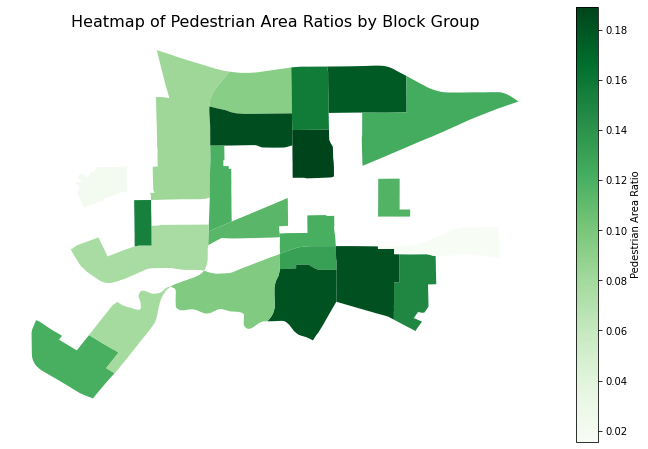

In [108]:
# Plot the heatmap for Pedestrian Area
fig, ax = plt.subplots(figsize=(12, 8))
BG_census_semantic_gdf.plot(
    ax=ax, 
    column="Pedestrian Area",  # Use the column for heatmap values
    cmap="Greens",             # Green colormap to represent pedestrian-friendly areas
    legend=True,               # Show legend for the heatmap
    legend_kwds={"label": "Pedestrian Area Ratio"}
)

# Add map title and remove axis
ax.set_title("Heatmap of Pedestrian Area Ratios by Block Group", fontsize=16)
ax.axis("off")

plt.show()

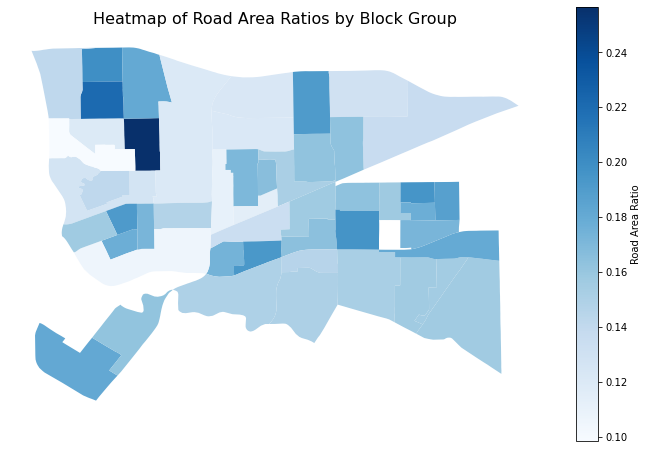

In [111]:
# Plot the heatmap for Pedestrian Area
fig, ax = plt.subplots(figsize=(12, 8))
BG_census_semantic_gdf.plot(
    ax=ax, 
    column="Road",  # Use the column for heatmap values
    cmap="Blues",             
    legend=True,               # Show legend for the heatmap
    legend_kwds={"label": "Road Area Ratio"}
)

# Add map title and remove axis
ax.set_title("Heatmap of Road Area Ratios by Block Group", fontsize=16)
ax.axis("off")

plt.show()

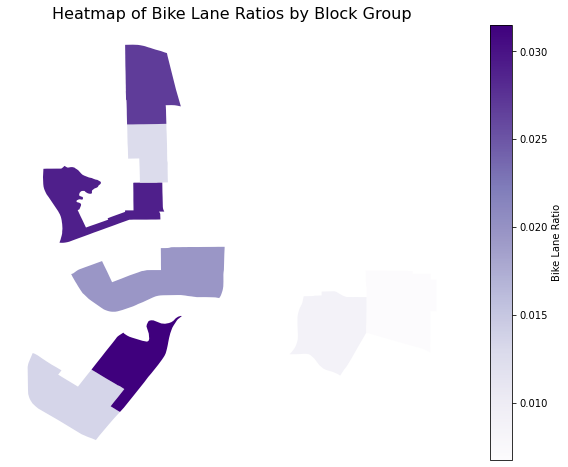

In [114]:
# Plot the heatmap for Bike Lanes
fig, ax = plt.subplots(figsize=(12, 8))
BG_census_semantic_gdf.plot(
    ax=ax, 
    column="Bike Lane",  # Use the column for heatmap values
    cmap="Purples",             
    legend=True,               # Show legend for the heatmap
    legend_kwds={"label": "Bike Lane Ratio"}
)

# Add map title and remove axis
ax.set_title("Heatmap of Bike Lane Ratios by Block Group", fontsize=16)
ax.axis("off")

plt.show()


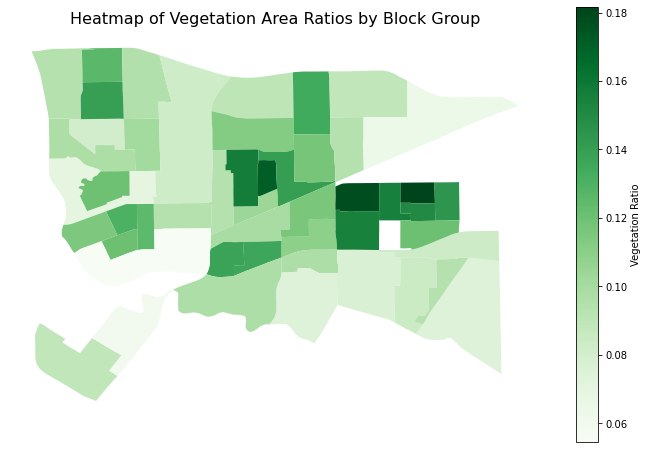

In [112]:
# Plot the heatmap for Pedestrian Area
fig, ax = plt.subplots(figsize=(12, 8))
BG_census_semantic_gdf.plot(
    ax=ax, 
    column="Vegetation",  # Use the column for heatmap values
    cmap="Greens",             
    legend=True,               # Show legend for the heatmap
    legend_kwds={"label": "Vegetation Ratio"}
)

# Add map title and remove axis
ax.set_title("Heatmap of Vegetation Area Ratios by Block Group", fontsize=16)
ax.axis("off")

plt.show()

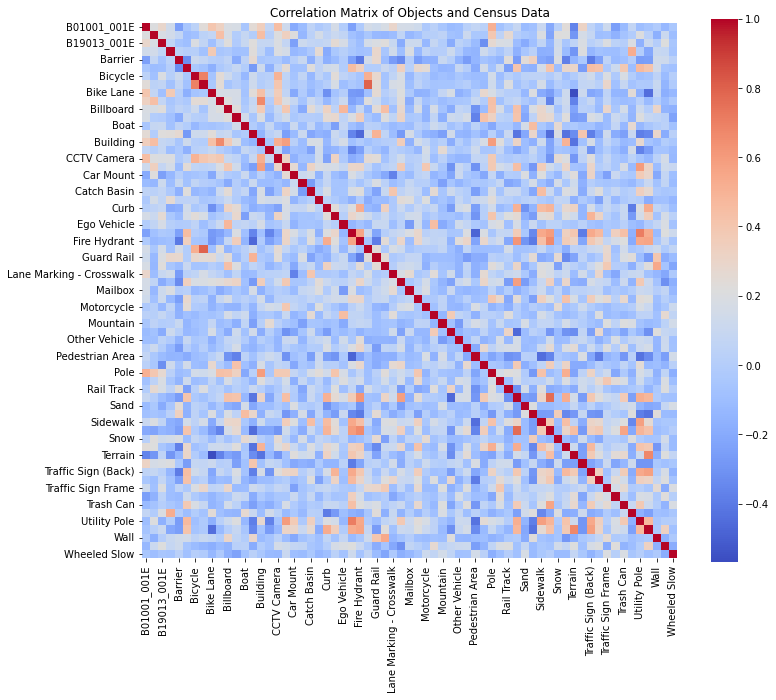

In [161]:
import seaborn as sns
import matplotlib.pyplot as plt



# Identify the dominant object (column with the highest ratio) for each block group
corr_columns =BG_census_semantic_gdf.columns.difference(["ALAND20", "geometry", 'AWATER20',
                                                'BLKGRPCE20', "GEOID20", "block_group_id", 
                                                'TRACTCE20', 'COUNTYFP20', 'FUNCSTAT20', 
                                                "color", 'INTPTLAT20', 'INTPTLON20', 'NAMELSAD20', 
                                                 "WKT", 'block group', 'county', 
                                                'state', 'tract', 'MTFCC20','STATEFP20', 'dominant_object'])


# Filter the GeoDataFrame to these columns
correlation_data = BG_census_semantic_gdf[corr_columns]
# Compute the correlation matrix
correlation_matrix = correlation_data.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix, 
    annot=False, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar=True,
    square=True
)
plt.title("Correlation Matrix of Objects and Census Data")
plt.show()


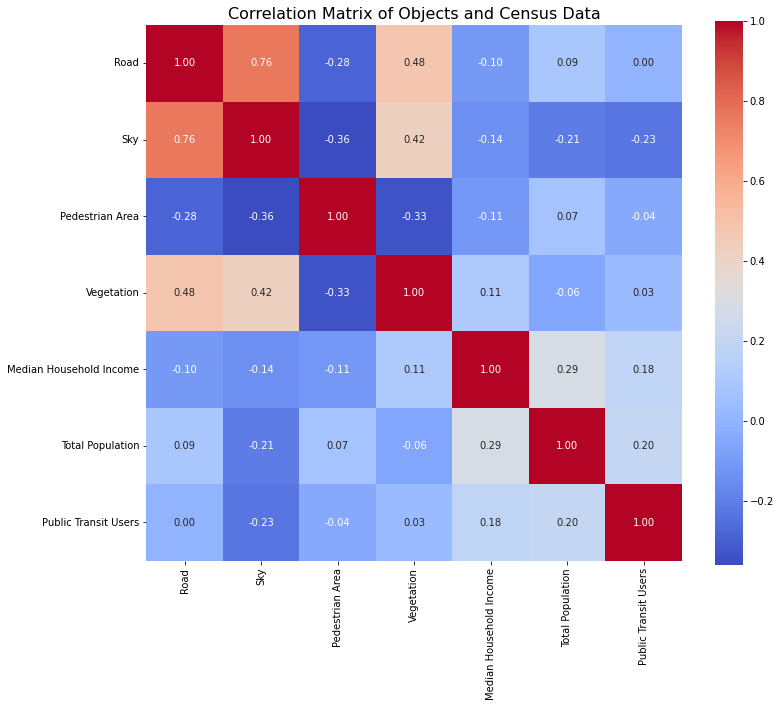

In [160]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a mapping from original column names to descriptive names
column_name_mapping = {
    "Road": "Road",
    "Sky": "Sky",
    "Pedestrian Area": "Pedestrian Area",
    "Vegetation": "Vegetation",
    "B19013_001E": "Median Household Income",
    "B01001_001E": "Total Population",
    "B08301_010E": "Public Transit Users"
}

# Select and rename the columns
smaller_corr_columns = ["Road", "Sky", "Pedestrian Area", "Vegetation", "B19013_001E", "B01001_001E", "B08301_010E"]
small_correlation_data = BG_census_semantic_gdf[smaller_corr_columns].rename(columns=column_name_mapping)

# Compute the correlation matrix
small_correlation_matrix = small_correlation_data.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    small_correlation_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar=True,
    square=True
)
plt.title("Correlation Matrix of Semantic Segmentation and Census Data", fontsize=16)
plt.show()


## Panoptic Segmentation Results

In [169]:
panoptic_mean_seg_pivot = mean_agg_labels.pivot(
    index="block_group_id",
    columns="label_name",
    values="avg_counts"
).reset_index()


panoptic_total_seg_pivot = sum_agg_labels.pivot(
    index="block_group_id",
    columns="label_name",
    values="total_counts"
).reset_index()

panoptic_mean_seg_pivot.head()

label_name,block_group_id,Banner,Barrier,Bench,Bicycle,Bicyclist,Bike Lane,Bike Rack,Billboard,Bird,...,Traffic Sign (Front),Traffic Sign Frame,Trailer,Trash Can,Truck,Utility Pole,Vegetation,Wall,Water,Wheeled Slow
0,482011000011,1.333333,1.0,1.25,1.142857,NaN,1.0,2.0,1.419355,1.666667,...,1.668675,1.000000,NaN,1.115385,1.0,2.000000,1.0,1.000000,1.0,NaN
1,482011000012,NaN,1.0,1.00,1.000000,1.0,1.0,1.0,1.468750,NaN,...,1.579310,1.166667,NaN,1.038462,1.0,2.280992,1.0,1.013699,1.0,NaN
2,482012104001,1.500000,1.0,1.00,1.000000,NaN,1.0,NaN,1.283333,1.000000,...,1.481481,NaN,NaN,1.725490,1.0,2.427653,1.0,1.000000,1.0,NaN
3,482012104002,1.000000,1.0,1.50,NaN,1.0,NaN,NaN,1.545455,NaN,...,1.390000,NaN,NaN,1.700000,1.0,2.567164,1.0,1.012987,1.0,NaN
4,482012105001,1.000000,1.0,1.00,NaN,NaN,NaN,NaN,1.580645,NaN,...,1.461538,NaN,NaN,1.333333,1.0,2.905882,1.0,1.000000,1.0,1.0


In [170]:
panoptic_total_seg_pivot.head()

label_name,block_group_id,Banner,Barrier,Bench,Bicycle,Bicyclist,Bike Lane,Bike Rack,Billboard,Bird,...,Traffic Sign (Front),Traffic Sign Frame,Trailer,Trash Can,Truck,Utility Pole,Vegetation,Wall,Water,Wheeled Slow
0,482011000011,4.0,5.0,15.0,8.0,NaN,11.0,2.0,176.0,5.0,...,277.0,1.0,NaN,29.0,10.0,152.0,377.0,78.0,6.0,NaN
1,482011000012,NaN,34.0,8.0,3.0,2.0,4.0,1.0,188.0,NaN,...,229.0,7.0,NaN,27.0,17.0,276.0,386.0,74.0,6.0,NaN
2,482012104001,3.0,6.0,7.0,1.0,NaN,3.0,NaN,77.0,2.0,...,120.0,NaN,NaN,88.0,10.0,755.0,388.0,64.0,3.0,NaN
3,482012104002,2.0,9.0,3.0,NaN,1.0,NaN,NaN,119.0,NaN,...,139.0,NaN,NaN,102.0,1.0,688.0,400.0,78.0,6.0,NaN
4,482012105001,1.0,7.0,2.0,NaN,NaN,NaN,NaN,49.0,NaN,...,38.0,NaN,NaN,8.0,4.0,247.0,114.0,29.0,1.0,1.0


In [174]:
# For total panoptic data 
BG50_gdf = BG50_gdf.copy()

# Ensure no issue with merging 
panoptic_total_seg_pivot.loc[:, 'block_group_id'] = panoptic_total_seg_pivot['block_group_id'].astype(str)
BG50_gdf.loc[:,'GEOID20'] = BG50_gdf['GEOID20'].astype(str)

# Merge census data with segmentation data
BG_census_panoptic_total_data = pd.merge(
    BG50_gdf, 
    panoptic_total_seg_pivot, 
    left_on="GEOID20", 
    right_on="block_group_id", 
    how="left"
)

BG_census_panoptic_total_data.head()

,WKT,STATEFP20,COUNTYFP20,TRACTCE20,BLKGRPCE20,GEOID20,NAMELSAD20,MTFCC20,FUNCSTAT20,ALAND20,...,Traffic Sign (Front),Traffic Sign Frame,Trailer,Trash Can,Truck,Utility Pole,Vegetation,Wall,Water,Wheeled Slow
0,"MULTIPOLYGON (((-95.374602 29.757612,-95.37457...",48,201,100001,1,482011000011,Block Group 1,G5030,S,1487729,...,277.0,1.0,NaN,29.0,10.0,152.0,377.0,78.0,6.0,NaN
1,"MULTIPOLYGON (((-95.362864 29.757924,-95.36227...",48,201,100001,2,482011000012,Block Group 2,G5030,S,1062631,...,229.0,7.0,NaN,27.0,17.0,276.0,386.0,74.0,6.0,NaN
2,"MULTIPOLYGON (((-95.371922 29.790763,-95.37184...",48,201,210400,1,482012104001,Block Group 1,G5030,S,1236805,...,120.0,NaN,NaN,88.0,10.0,755.0,388.0,64.0,3.0,NaN
3,"MULTIPOLYGON (((-95.366088 29.786579,-95.36599...",48,201,210400,2,482012104002,Block Group 2,G5030,S,575150,...,139.0,NaN,NaN,102.0,1.0,688.0,400.0,78.0,6.0,NaN
4,"MULTIPOLYGON (((-95.367937 29.798186,-95.36792...",48,201,210500,1,482012105001,Block Group 1,G5030,S,598129,...,38.0,NaN,NaN,8.0,4.0,247.0,114.0,29.0,1.0,1.0


In [175]:
# For av count panoptic data 
BG50_gdf = BG50_gdf.copy()

# Ensure no issue with merging 
panoptic_mean_seg_pivot.loc[:, 'block_group_id'] = panoptic_mean_seg_pivot['block_group_id'].astype(str)
BG50_gdf.loc[:,'GEOID20'] = BG50_gdf['GEOID20'].astype(str)

# Merge census data with segmentation data
BG_census_panoptic_avg_data = pd.merge(
    BG50_gdf, 
    panoptic_mean_seg_pivot, 
    left_on="GEOID20", 
    right_on="block_group_id", 
    how="left"
)

BG_census_panoptic_avg_data.head()

,WKT,STATEFP20,COUNTYFP20,TRACTCE20,BLKGRPCE20,GEOID20,NAMELSAD20,MTFCC20,FUNCSTAT20,ALAND20,...,Traffic Sign (Front),Traffic Sign Frame,Trailer,Trash Can,Truck,Utility Pole,Vegetation,Wall,Water,Wheeled Slow
0,"MULTIPOLYGON (((-95.374602 29.757612,-95.37457...",48,201,100001,1,482011000011,Block Group 1,G5030,S,1487729,...,1.668675,1.000000,NaN,1.115385,1.0,2.000000,1.0,1.000000,1.0,NaN
1,"MULTIPOLYGON (((-95.362864 29.757924,-95.36227...",48,201,100001,2,482011000012,Block Group 2,G5030,S,1062631,...,1.579310,1.166667,NaN,1.038462,1.0,2.280992,1.0,1.013699,1.0,NaN
2,"MULTIPOLYGON (((-95.371922 29.790763,-95.37184...",48,201,210400,1,482012104001,Block Group 1,G5030,S,1236805,...,1.481481,NaN,NaN,1.725490,1.0,2.427653,1.0,1.000000,1.0,NaN
3,"MULTIPOLYGON (((-95.366088 29.786579,-95.36599...",48,201,210400,2,482012104002,Block Group 2,G5030,S,575150,...,1.390000,NaN,NaN,1.700000,1.0,2.567164,1.0,1.012987,1.0,NaN
4,"MULTIPOLYGON (((-95.367937 29.798186,-95.36792...",48,201,210500,1,482012105001,Block Group 1,G5030,S,598129,...,1.461538,NaN,NaN,1.333333,1.0,2.905882,1.0,1.000000,1.0,1.0


In [179]:
# Create a new column for the dominant object
BG_census_panoptic_total_data["dominant_object"] = BG_census_panoptic_total_data[object_columns].idxmax(axis=1)
print(BG_census_panoptic_total_data["dominant_object"].unique())

['Car' 'Utility Pole']


['Car' 'Utility Pole']


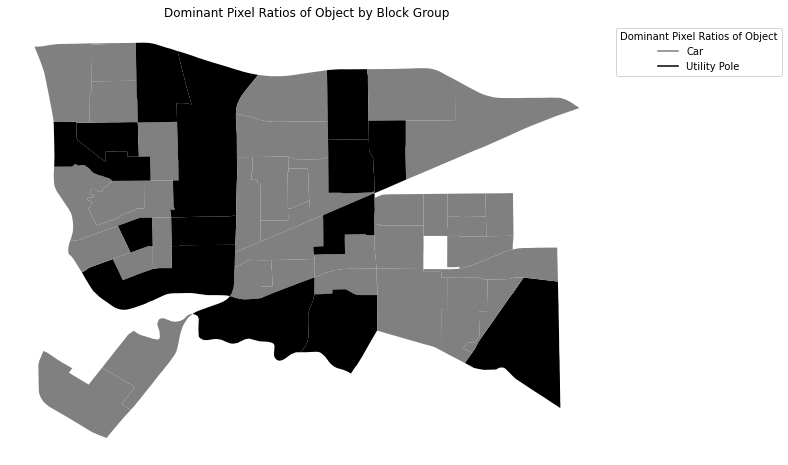

In [184]:

# Create a color map for the dominant objects
unique_objects = BG_census_panoptic_total_data["dominant_object"].unique()
print(unique_objects)
# Define custom colors for dominant objects
panoptic_color_map = {
    "Car": "#549aab",         
    "Utility Pole": "#f1802d"  
}
# Map the colors to the dominant object for plotting
BG_census_panoptic_total_data["color"] = BG_census_panoptic_total_data["dominant_object"].map(panoptic_color_map)

# Plot the map with colors based on the dominant object
fig, ax = plt.subplots(figsize=(12, 8))
BG_census_panoptic_total_data.plot(ax=ax, color=BG_census_panoptic_total_data["color"])

# Add legend for dominant objects
for obj, color in panoptic_color_map.items():
    ax.plot([], [], color=color, label=obj)
ax.legend(title="Dominant Object Instances", loc="upper right", bbox_to_anchor=(1.3, 1))

ax.set_title("Dominant Object Instances by Block Group")
ax.axis("off")

plt.show()

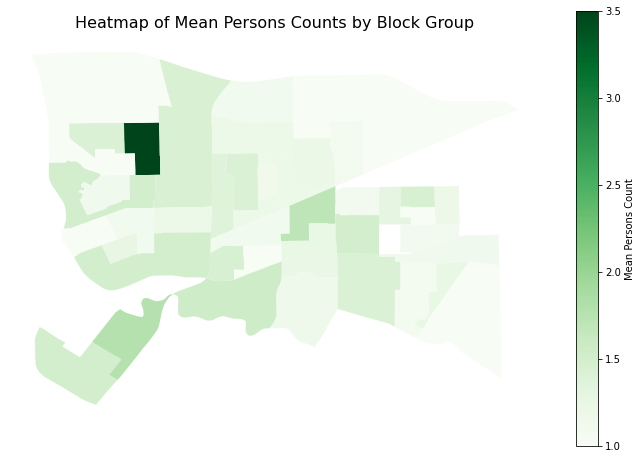

In [187]:
# Plot the heatmap for Persons (Mean)
fig, ax = plt.subplots(figsize=(12, 8))
BG_census_panoptic_avg_data.plot(
    ax=ax, 
    column="Person",  # Use the column for heatmap values
    cmap="Greens",             
    legend=True,               # Show legend for the heatmap
    legend_kwds={"label": "Mean Persons Count"}
)

# Add map title and remove axis
ax.set_title("Heatmap of Mean Persons Counts by Block Group", fontsize=16)
ax.axis("off")

plt.show()

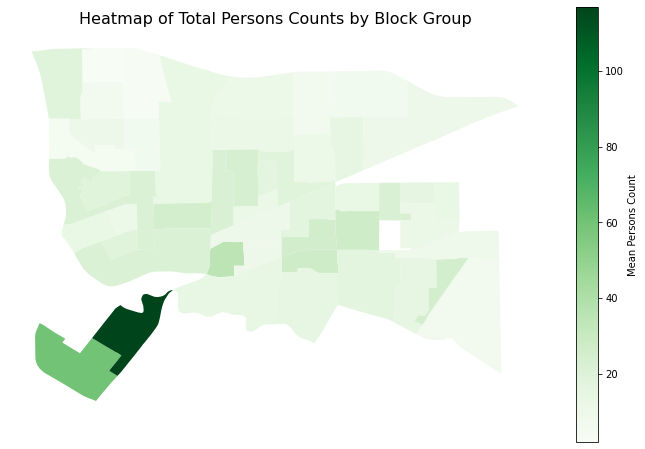

In [188]:
# Plot the heatmap for Persons (Total)
fig, ax = plt.subplots(figsize=(12, 8))
BG_census_panoptic_total_data.plot(
    ax=ax, 
    column="Person",  # Use the column for heatmap values
    cmap="Greens",             
    legend=True,               # Show legend for the heatmap
    legend_kwds={"label": "Mean Persons Count"}
)

# Add map title and remove axis
ax.set_title("Heatmap of Total Persons Counts by Block Group", fontsize=16)
ax.axis("off")

plt.show()

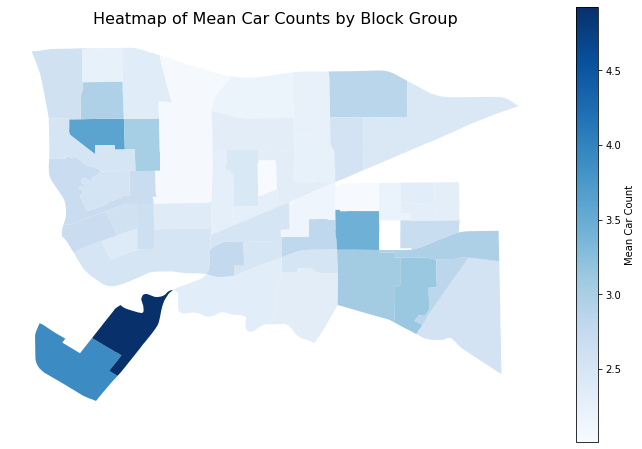

In [190]:
# Plot the heatmap for Cars (Mean)
fig, ax = plt.subplots(figsize=(12, 8))
BG_census_panoptic_avg_data.plot(
    ax=ax, 
    column="Car",  # Use the column for heatmap values
    cmap="Blues",             
    legend=True,               # Show legend for the heatmap
    legend_kwds={"label": "Mean Car Count"}
)

# Add map title and remove axis
ax.set_title("Heatmap of Mean Car Counts by Block Group", fontsize=16)
ax.axis("off")

plt.show()

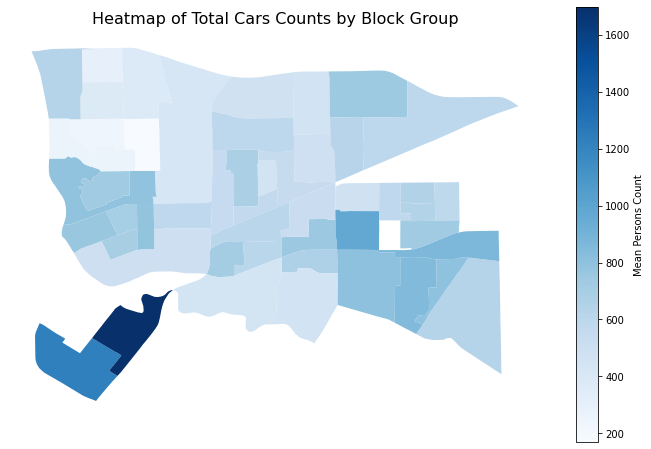

In [191]:
# Plot the heatmap for Persons (Total)
fig, ax = plt.subplots(figsize=(12, 8))
BG_census_panoptic_total_data.plot(
    ax=ax, 
    column="Car",  # Use the column for heatmap values
    cmap="Blues",             
    legend=True,               # Show legend for the heatmap
    legend_kwds={"label": "Mean Persons Count"}
)

# Add map title and remove axis
ax.set_title("Heatmap of Total Cars Counts by Block Group", fontsize=16)
ax.axis("off")

plt.show()

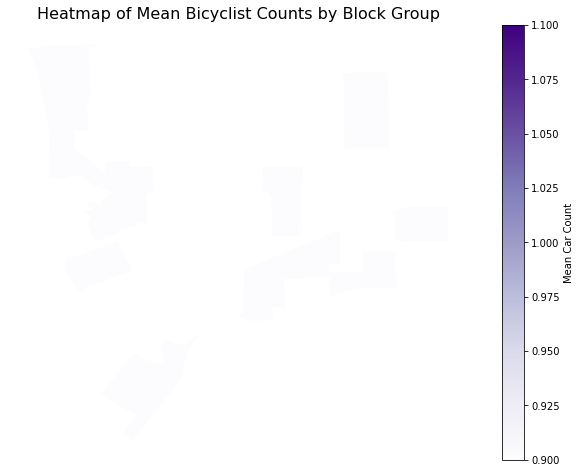

In [192]:
# Plot the heatmap for Bicyclists (Mean)
fig, ax = plt.subplots(figsize=(12, 8))
BG_census_panoptic_avg_data.plot(
    ax=ax, 
    column="Bicyclist",  # Use the column for heatmap values
    cmap="Purples",             
    legend=True,               # Show legend for the heatmap
    legend_kwds={"label": "Mean Bicyclist Count"}
)

# Add map title and remove axis
ax.set_title("Heatmap of Mean Bicyclist Counts by Block Group", fontsize=16)
ax.axis("off")

plt.show()



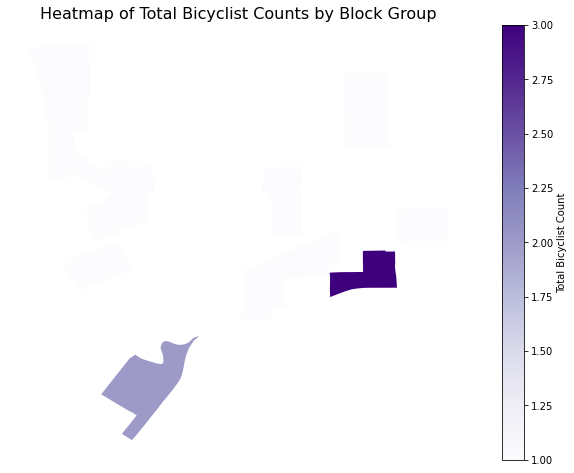

In [194]:
# Plot the heatmap for Persons (Total)
fig, ax = plt.subplots(figsize=(12, 8))
BG_census_panoptic_total_data.plot(
    ax=ax, 
    column="Bicyclist",  # Use the column for heatmap values
    cmap="Purples",             
    legend=True,               # Show legend for the heatmap
    legend_kwds={"label": "Total Bicyclist Count"}
)

# Add map title and remove axis
ax.set_title("Heatmap of Total Bicyclist Counts by Block Group", fontsize=16)
ax.axis("off")

plt.show()

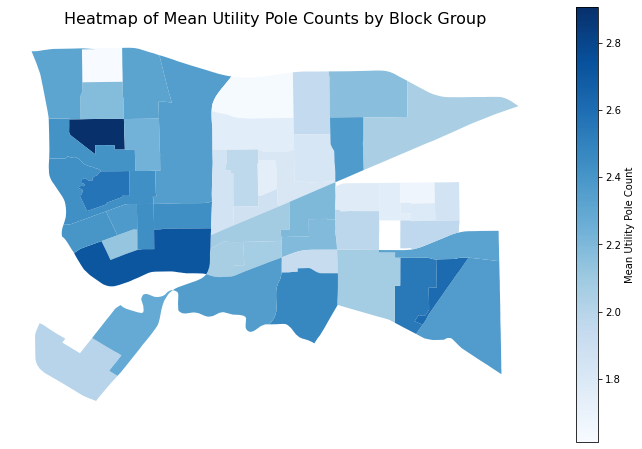

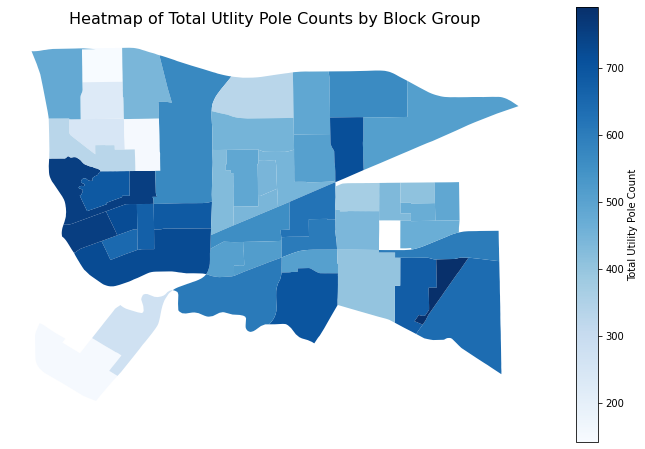

In [195]:
# Plot the heatmap for Bicyclists (Mean)
fig, ax = plt.subplots(figsize=(12, 8))
BG_census_panoptic_avg_data.plot(
    ax=ax, 
    column="Utility Pole",  # Use the column for heatmap values
    cmap="Blues",             
    legend=True,               # Show legend for the heatmap
    legend_kwds={"label": "Mean Utility Pole Count"}
)

# Add map title and remove axis
ax.set_title("Heatmap of Mean Utility Pole Counts by Block Group", fontsize=16)
ax.axis("off")

plt.show()

# Plot the heatmap for Persons (Total)
fig, ax = plt.subplots(figsize=(12, 8))
BG_census_panoptic_total_data.plot(
    ax=ax, 
    column="Utility Pole",  # Use the column for heatmap values
    cmap="Blues",             
    legend=True,               # Show legend for the heatmap
    legend_kwds={"label": "Total Utility Pole Count"}
)

# Add map title and remove axis
ax.set_title("Heatmap of Total Utlity Pole Counts by Block Group", fontsize=16)
ax.axis("off")

plt.show()

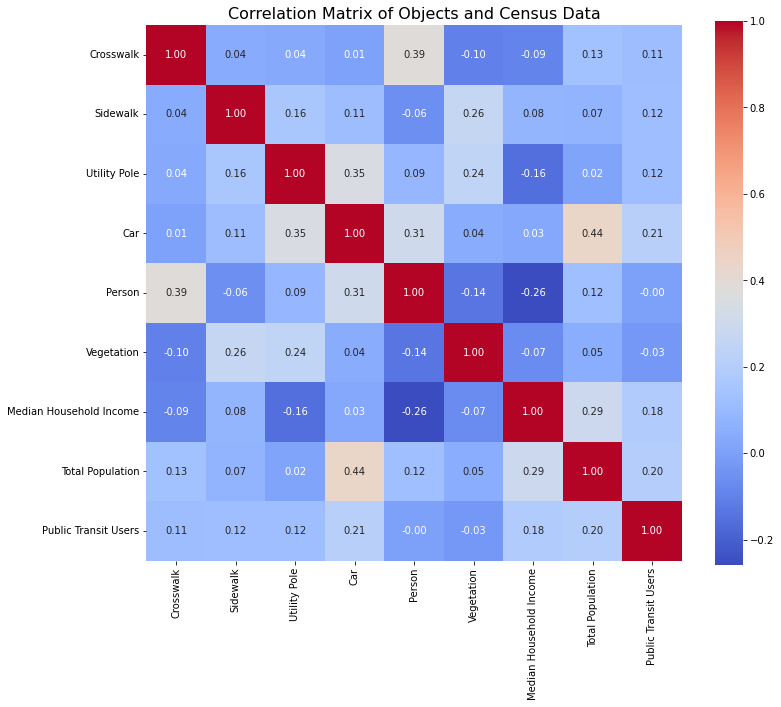

In [201]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a mapping from original column names to descriptive names
column_name_mapping = {
    "Lane Marking - Crosswalk":"Crosswalk",
    "Sidewalk": "Sidewalk",
    "Utility Pole": "Utility Pole",
    "Car": "Car",
    "Person": "Person",
    "Vegetation": "Vegetation",
    "B19013_001E": "Median Household Income",
    "B01001_001E": "Total Population",
    "B08301_010E": "Public Transit Users"
}

# Select and rename the columns
smaller_corr_columns = ["Lane Marking - Crosswalk", "Sidewalk", "Utility Pole", "Car", "Person", "Vegetation", "B19013_001E", "B01001_001E", "B08301_010E"]
small_corr_panoptic_data = BG_census_panoptic_avg_data[smaller_corr_columns].rename(columns=column_name_mapping)

# Compute the correlation matrix
small_corr_panoptic_matrix = small_corr_panoptic_data.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    small_corr_panoptic_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar=True,
    square=True
)
plt.title("Correlation Matrix of Objects and Census Data", fontsize=16)
plt.show()


In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

# Pivot segmentation data to create one column per object type
panoptic_segmentation_pivot = panoptic_data.pivot(
    index="block_group_id",
    columns="label_name",
    values="relative_ratios"
).reset_index()

# Make a copy of BG50 
BG50_gdf = BG50_gdf.copy()

# Ensure no issue with merging 
segmentation_pivot.loc[:, 'block_group_id'] = segmentation_pivot['block_group_id'].astype(str)
BG50_gdf.loc[:, 'GEOID20'] = BG50_gdf['GEOID20'].astype(str)

# Merge census data with segmentation data
BG_census_semantic_data = pd.merge(
    BG50_gdf, 
    segmentation_pivot, 
    left_on="GEOID20", 
    right_on="block_group_id", 
    how="left"
)

# Convert merged data into a GeoDataFrame
BG_census_semantic_gdf = gpd.GeoDataFrame(BG_census_semantic_data, geometry="geometry")

# Fill Nan values as 0 
BG_census_semantic_gdf = BG_census_semantic_gdf.fillna(0)
BG_census_semantic_gdf.head()

In [5]:
# Calculate relative proportions of object types within each block group
# First, compute total counts per block_group_id
total_counts_per_group = (
    aggregated_data.groupby('block_group_id')['total_counts'].sum().reset_index()
)
total_counts_per_group.rename(columns={'total_counts': 'group_total_counts'}, inplace=True)
total_counts_per_group.head()

,block_group_id,group_total_counts
0,482011000011,6429.0
1,482011000012,7009.0
2,482012104001,5243.0
3,482012104002,5424.0
4,482012105001,1704.0


In [6]:

# Merge total counts back into the aggregated data
aggregated_data = aggregated_data.merge(
    total_counts_per_group, on='block_group_id', how='left'
)

# Calculate proportions for each label_name within each block group
aggregated_data['relative_proportion'] = (
    aggregated_data['total_counts'] / aggregated_data['group_total_counts']
)
aggregated_data.head()

,block_group_id,label_name,total_counts,group_total_counts,relative_proportion
0,482011000011,Banner,4.0,6429.0,0.000622
1,482011000011,Barrier,5.0,6429.0,0.000778
2,482011000011,Bench,15.0,6429.0,0.002333
3,482011000011,Bicycle,8.0,6429.0,0.001244
4,482011000011,Bike Lane,11.0,6429.0,0.001711


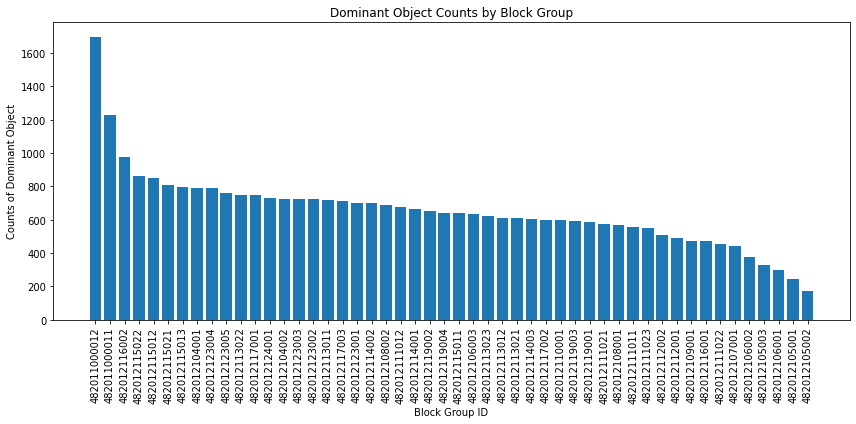

In [7]:
import matplotlib.pyplot as plt

# Plot dominant objects for block groups
plt.figure(figsize=(12, 6))
dominant_objects_sorted = dominant_objects.sort_values('total_counts', ascending=False)
plt.bar(dominant_objects_sorted['block_group_id'], dominant_objects_sorted['total_counts'])
plt.xlabel('Block Group ID')
plt.ylabel('Counts of Dominant Object')
plt.title('Dominant Object Counts by Block Group')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


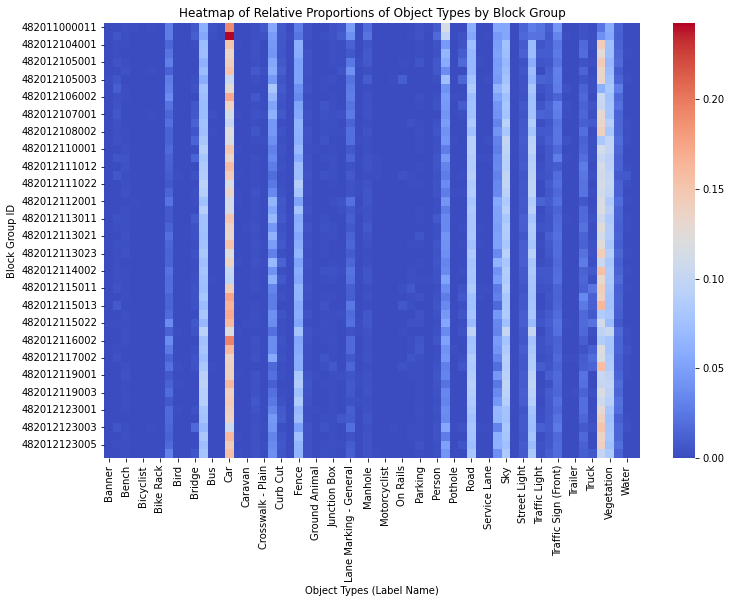

In [9]:
import seaborn as sns

# Create a pivot table for proportions
pivot_table = aggregated_data.pivot(
    index='block_group_id', columns='label_name', values='relative_proportion'
).fillna(0)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='coolwarm', annot=False)
plt.title('Heatmap of Relative Proportions of Object Types by Block Group')
plt.xlabel('Object Types (Label Name)')
plt.ylabel('Block Group ID')
plt.show()


  block_group_id  shannon_diversity
0   482011000011           2.946610
1   482011000012           2.906155
2   482012104001           2.796193
3   482012104002           2.859210
4   482012105001           2.874977


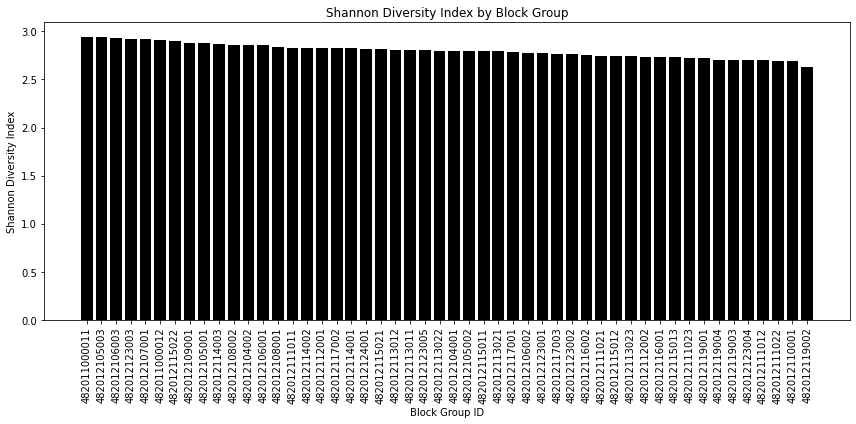

In [14]:
import numpy as np

# Step 1: Calculate proportions for each label_name in each block group
aggregated_data['relative_proportion'] = (
    aggregated_data['total_counts'] / aggregated_data['group_total_counts']
)

# Step 2: Define a function to compute the Shannon Diversity Index
def calculate_shannon_diversity(group):
    proportions = group['relative_proportion']
    return -np.sum(proportions * np.log(proportions))

# Step 3: Apply the function to each block group
diversity_index = (
    aggregated_data.groupby('block_group_id')
    .apply(calculate_shannon_diversity)
    .reset_index(name='shannon_diversity')
)

# Display the diversity index for each block group
print(diversity_index.head())
"""
# Save the results to a CSV file
diversity_index.to_csv('shannon_diversity_index.csv', index=False)
"""
# Bar plot of diversity index
plt.figure(figsize=(12, 6))
diversity_index_sorted = diversity_index.sort_values('shannon_diversity', ascending=False)
plt.bar(diversity_index_sorted['block_group_id'], diversity_index_sorted['shannon_diversity'], color='k')
plt.xlabel('Block Group ID')
plt.ylabel('Shannon Diversity Index')
plt.title('Shannon Diversity Index by Block Group')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


  block_group_id  simpson_diversity
0   482011000011           0.921595
1   482011000012           0.907327
2   482012104001           0.918238
3   482012104002           0.926226
4   482012105001           0.924115


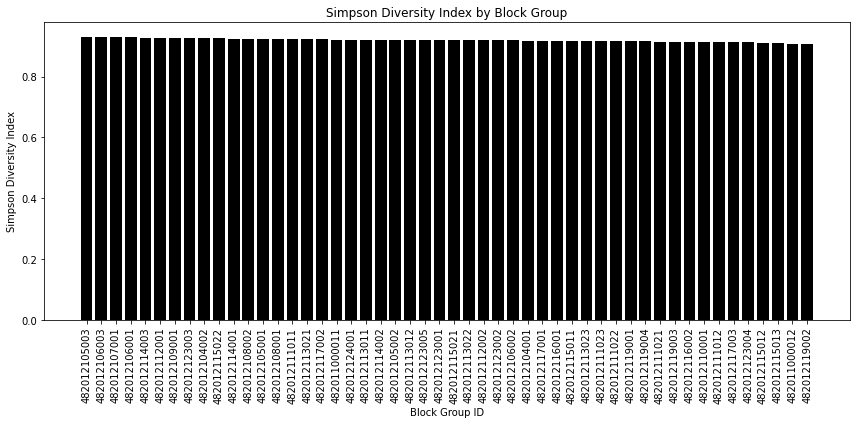

In [13]:
# Function to compute Simpson's Diversity Index
def calculate_simpson_diversity(group):
    proportions = group['relative_proportion']
    return 1 - np.sum(proportions**2)

# Apply the function to each block group
simpson_diversity = (
    aggregated_data.groupby('block_group_id')
    .apply(calculate_simpson_diversity)
    .reset_index(name='simpson_diversity')
)

print(simpson_diversity.head())
# Bar plot of diversity index
plt.figure(figsize=(12, 6))
diversity_index_sorted = simpson_diversity.sort_values('simpson_diversity', ascending=False)
plt.bar(diversity_index_sorted['block_group_id'], diversity_index_sorted['simpson_diversity'], color = 'k')
plt.xlabel('Block Group ID')
plt.ylabel('Simpson Diversity Index')
plt.title('Simpson Diversity Index by Block Group')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
# Save outputs if needed
dominant_objects.to_csv('dominant_objects_per_block_group.csv', index=False)
aggregated_data.to_csv('label_proportions_per_block_group.csv', index=False)

# Display results
print("Dominant Objects per Block Group:")
print(dominant_objects.head())

print("\nRelative Proportions of Labels in Each Block Group:")
print(aggregated_data.head())
